In [1]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [2]:
_set_env("TAVILY_API_KEY")

In [3]:
_set_env("ANTHROPIC_API_KEY")

In [5]:
from typing import Annotated, Literal

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.pydantic_v1 import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State) -> Literal["human", "tools", "__end__"]:
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

In [6]:
llm.invoke("Om namah shivay")

AIMessage(content='Om Namah Shivaya is a popular Hindu mantra and prayer that translates to "I bow to Shiva". It is a sacred expression of reverence and devotion to the Hindu deity Lord Shiva, who is seen as the supreme god in Hindu philosophy and mythology.\n\nThe mantra is considered extremely powerful and is chanted by Hindus for various purposes, such as:\n\n1. Spiritual enlightenment and self-realization.\n2. Purification of the mind and body.\n3. Invoking the blessings and grace of Lord Shiva.\n4. Gaining inner peace, strength, and clarity.\n5. Overcoming obstacles and challenges in life.\n\nChanting Om Namah Shivaya is believed to connect the individual to the divine energy and consciousness of Lord Shiva, which is seen as the source of all creation, preservation, and transformation in the universe. The mantra is often repeated as part of Shiva-related spiritual practices, meditation, and rituals.', response_metadata={'id': 'msg_011v3auymqdMkpuAjJGutWA4', 'model': 'claude-3-haik

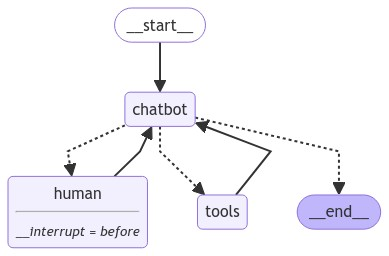

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "I'm learning LangGraph. Could you do some research on it for me?")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

[{'text': "Okay, let's look into LangGraph for you. Here is a search for information on LangGraph:", 'type': 'text'}, {'id': 'toolu_0195AFYRWH3NebYKGXuSKcDJ', 'input': {'query': 'LangGraph'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_0195AFYRWH3NebYKGXuSKcDJ)
 Call ID: toolu_0195AFYRWH3NebYKGXuSKcDJ
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://ithelp.ithome.com.tw/articles/10347147", "content": "LangGraph \u4e32\u6d41\u61c9\u7528\uff1a\u63a2\u7d22\u9ad8\u6548\u7684\u8cc7\u6599\u8655\u7406\u65b9\u6848. \u5728\u73fe\u4ee3\u8cc7\u6599\u8655\u7406\u548c\u4eba\u5de5\u667a\u6167\u61c9\u75

In [9]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it!")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

[{'text': "That's great, building an autonomous agent with LangGraph sounds like an interesting project! Here are a few additional thoughts on how you could potentially use LangGraph for that:", 'type': 'text'}, {'id': 'toolu_01CzaWsqbnd6Tx8rxsS47P9J', 'input': {'query': 'using langGraph for autonomous agents'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01CzaWsqbnd6Tx8rxsS47P9J)
 Call ID: toolu_01CzaWsqbnd6Tx8rxsS47P9J
  Args:
    query: using langGraph for autonomous agents
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://vijaykumarkartha.medium.com/multiple-ai-agents-creating-multi-agent-workflows-using-langgraph

In [10]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
-----------------------------------------

In [11]:
print(to_replay.next)
print(to_replay.config)

('tools',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1ef695be-b000-669a-8006-817769699206'}}


In [12]:
# The `thread_ts` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://vijaykumarkartha.medium.com/multiple-ai-agents-creating-multi-agent-workflows-using-langgraph-and-langchain-0587406ec4e6", "content": "Using LangGraph for Multi-Agent Workflows. LangGraph is well-suited for creating multi-agent workflows because it allows two or more agents to be connected as a graph. Each agent is an independent actor, and the connections between agents are represented by edges. ... AI agents are autonomous programs designed to perceive their environment and ..."}, {"url": "https://blog.langchain.dev/how-to-build-the-ultimate-ai-automation-with-multi-agent-collaboration/", "content": "This is the \"master\" agent that coordinates the other agents using LangGraph. This agent acts as the main LangGraph interface. GPT Researcher \u2014 A specialized autonomous agent that conducts in depth research on a given topic. Editor \u2014 Responsible